## Alternus Vera Final Notebook

###  By - Avleen Singh Khanuja - ML Learners

#### Fake News Detection by performing "DISTILLATION" on the LIAR DATASET.

Steps for performing Distillation:
    1. Data Preprocessing - Tokenization, Stemming, Lemmatization, Removal of Punctuation MArks, etc.
    2. Sentiment Analysis
    3. Latent Dirichlet Allocation (LDA) - Topic Modeling
    4. TF-IDF Vectorizer - Feature Extraction & Vector Conversion
    5. Random Forest Classifier  - For evaluation of a Factor

#### Data Loading

In [403]:
import pandas as pd
data= pd.read_csv('liar_dataset/train_liar.csv', error_bad_lines=False, sep=",", names = ['ID','Label','Statement','Subject','Speaker','Speakers Job Title','State Info','Party Affiliation','Barely True Counts','False Counts',' Half True Counts','Mostly True Counts','Pants On Fire Counts','The Context'])

In [404]:
data.describe()

,Barely True Counts,False Counts,Half True Counts,Mostly True Counts,Pants On Fire Counts
count,10263.000000,10263.000000,10263.000000,10263.000000,10263.000000
mean,11.549839,13.304394,17.168762,16.465166,6.202670
std,18.992224,24.132578,35.899983,36.202646,16.121555
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,3.000000,3.000000,1.000000
75%,12.000000,15.000000,13.000000,11.000000,5.000000
max,70.000000,114.000000,160.000000,163.000000,105.000000


#### Cleaning the Data

In [405]:
data.isnull().values.any()

True

In [406]:
null_columns=data.columns[data.isnull().any()]

In [407]:
null_columns

Index(['Subject', 'Speaker', 'Speakers Job Title', 'State Info',
       'Party Affiliation', 'Barely True Counts', 'False Counts',
       ' Half True Counts', 'Mostly True Counts', 'Pants On Fire Counts',
       'The Context'],
      dtype='object')

In [408]:
data = data.replace(np.nan, 'NA', regex=True)

In [409]:
data.isnull().values.any()

False

In [410]:
data.shape

(10269, 14)

#### Separating the Text data from dataset and storing it as a List of Documents

In [411]:
data_text = data[['Statement']]
data_text['index'] = data_text.index
documents = data_text

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Printing Length of documents

In [412]:
print(len(documents))
print(documents[:5])

10269
                                           Statement  index
0  Says the Annies List political group supports ...      0
1  When did the decline of coal start? It started...      1
2  Hillary Clinton agrees with John McCain "by vo...      2
3  Health care reform legislation is likely to ma...      3
4  The economic turnaround started at the end of ...      4


#### Stemming, Lemmatizing & Tokeninzing

The data preprocessing step consists of further 3 more steps:

1. Tokenizing : Cleaning the data to break the text we have in the Statement column into sentences and sentences further into words. Then, convert all uppercase words to lowercase to achieve standardization and remove punctuation to avoid unnecessary barriers.

2. Stopwords: Removed stop words using a function by first creating a dictionary of stopwords after identifying them and then looping over the documents to check the presence of stopwords and remove them.

3. Word shortening: The words with less than three characters are removed.

4. Lemmatization: Changed the speech of words from third person to first person and also verbs in past and future tense converted to present tense.

5. Stemming: Used Snowball Stemmer library to reduce words to their roots.

#### Loading gensim and nltk libraries

In [413]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rashmeet\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### Tokenization, Lemmatizing and Stemming Preprocessing via Function

In [414]:
def lemmatize_stemming(text):
    stemmer = SnowballStemmer("english")
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

#### Document preview after preprocessing

In [415]:
doc_sample = documents[documents['index'] == 4310].values[0][0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['Says', 'state', 'Sen.', 'Morgan', 'Carrolls', 'votes', 'made', 'it', 'easier', 'to', 'sue', 'doctors,', 'small', 'businesses,', 'even', 'nurses.', 'Putting', 'her', 'own', 'shady', 'interests', 'first.']


 tokenized and lemmatized document: 
['say', 'state', 'morgan', 'carrol', 'vote', 'easier', 'doctor', 'small', 'busi', 'nurs', 'put', 'shadi', 'interest']


In [416]:
processed_docs = documents['Statement'].map(preprocess)
processed_docs[:10]

0    [say, anni, list, polit, group, support, trime...
1    [declin, coal, start, start, natur, take, star...
2    [hillari, clinton, agre, john, mccain, vote, g...
3    [health, care, reform, legisl, like, mandat, f...
4                    [econom, turnaround, start, term]
5    [chicago, bear, start, quarterback, year, tota...
6               [dunnam, live, district, repres, year]
7    [person, stage, work, activ, year, pass, russ,...
8    [take, million, oregon, lotteri, fund, port, n...
9    [say, primari, oppon, glenn, grothman, leibham...
Name: Statement, dtype: object

#### Imports for Sentiment Analysis

In [417]:
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#### Creation of Word Features to be fed to Naive Base Classifier - DATA PREPERATION

In [418]:
# This is how the Naive Bayes classifier expects the input
def create_word_features(words):
    useful_words = [word for word in words if word not in stopwords.words("english")]
    my_dict = dict([(word, True) for word in useful_words])
    return my_dict

In [419]:
data['Label'] = pd.Series(data['Label'])

#### Data Slicing

In [420]:
data_slice = data[['Label','Statement']]
data_slice.head()

,Label,Statement
0,FALSE,Says the Annies List political group supports ...
1,half-true,When did the decline of coal start? It started...
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo..."
3,FALSE,Health care reform legislation is likely to ma...
4,half-true,The economic turnaround started at the end of ...


#### Feature Visualization by Count

In [421]:
True_len = data_slice[data_slice['Label'] == 'TRUE'].shape[0]
False_len = data_slice[data_slice['Label'] == 'FALSE'].shape[0]
Barely_true_len = data_slice[data_slice['Label'] == 'barely-true'].shape[0]
Mostly_true_len = data_slice[data_slice['Label'] == 'mostly-true'].shape[0]
Half_true_len = data_slice[data_slice['Label'] == 'half-true'].shape[0]
Pants_fire_len = data_slice[data_slice['Label'] == 'pants-fire'].shape[0]

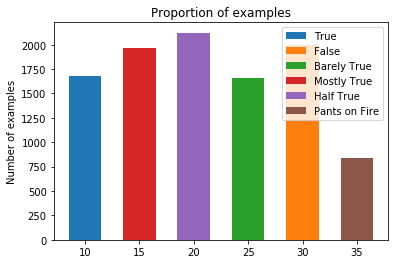

In [422]:
import matplotlib
from matplotlib import pyplot as plt

plt.bar(10, True_len,3, label="True")
plt.bar(30,False_len,3, label="False")
plt.bar(25,Barely_true_len,3, label="Barely True")
plt.bar(15,Mostly_true_len,3, label="Mostly True")
plt.bar(20,Half_true_len,3, label="Half True")
plt.bar(35,Pants_fire_len,3, label="Pants on Fire")

plt.legend()
plt.ylabel('Number of examples')
plt.title('Proportion of examples')
plt.show()

#### Separation of multiple classes for extraction of Sentiment

#### Data Slice for classes expressing the 'Not Fake News' sentiment

In [423]:
temp_data_slice_true = data_slice.loc[(data_slice['Label'] == 'half-true') | (data_slice['Label'] == 'mostly-true') | (data_slice['Label'] == 'TRUE')]
temp_data_slice_true.head(5)

,Label,Statement
1,half-true,When did the decline of coal start? It started...
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo..."
4,half-true,The economic turnaround started at the end of ...
5,TRUE,The Chicago Bears have had more starting quart...
7,half-true,I'm the only person on this stage who has work...


#### Sentiment Preprocessing

In [424]:
data_text_true = temp_data_slice_true[['Statement']]
data_text_true['index'] = data_text_true.index
documents_true = data_text_true

In [425]:
doc_sample_true = documents_true[documents_true['index'] == 1].values[0][0]
print('original document: ')
words_true = []
for word_true in doc_sample_true.split(' '):
    words_true.append(word_true)
print(words_true)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample_true))

original document: 
['When', 'did', 'the', 'decline', 'of', 'coal', 'start?', 'It', 'started', 'when', 'natural', 'gas', 'took', 'off', 'that', 'started', 'to', 'begin', 'in', '(President', 'George', 'W.)', 'Bushs', 'administration.']


 tokenized and lemmatized document: 
['declin', 'coal', 'start', 'start', 'natur', 'take', 'start', 'begin', 'presid', 'georg', 'bush', 'administr']


In [426]:
processed_docs_true = documents_true['Statement'].map(preprocess)
processed_docs_true[:10]

1     [declin, coal, start, start, natur, take, star...
2     [hillari, clinton, agre, john, mccain, vote, g...
4                     [econom, turnaround, start, term]
5     [chicago, bear, start, quarterback, year, tota...
7     [person, stage, work, activ, year, pass, russ,...
8     [take, million, oregon, lotteri, fund, port, n...
9     [say, primari, oppon, glenn, grothman, leibham...
10    [time, histori, share, nation, popular, vote, ...
11    [near, million, american, slip, middl, class, ...
13          [economi, bleed, billion, govern, shutdown]
Name: Statement, dtype: object

#### Sentiment 'true' Extraction

In [427]:
true_news = []

for docs_true in processed_docs_true:
    true_news.append((create_word_features(docs_true), "true"))
print(true_news[0])    
print(len(true_news))

({'declin': True, 'coal': True, 'start': True, 'natur': True, 'take': True, 'begin': True, 'presid': True, 'georg': True, 'bush': True, 'administr': True}, 'true')
5772


#### Data Slice for classes expressing the 'Fake News' sentiment

In [428]:
temp_data_slice_fake = data_slice.loc[(data_slice['Label'] == 'barely-true') | (data_slice['Label'] == 'FALSE') | (data_slice['Label'] == 'pants-fire')]
temp_data_slice_fake.head(5)

,Label,Statement
0,FALSE,Says the Annies List political group supports ...
3,FALSE,Health care reform legislation is likely to ma...
6,barely-true,Jim Dunnam has not lived in the district he re...
12,FALSE,When Mitt Romney was governor of Massachusetts...
14,barely-true,Most of the (Affordable Care Act) has already ...


#### Sentiment Preprocessing

In [429]:
data_text_fake = temp_data_slice_fake[['Statement']]
data_text_fake['index'] = data_text_fake.index
documents_fake = data_text_fake

In [430]:
doc_sample_fake = documents_fake[documents_fake['index'] == 3].values[0][0]
print('original document: ')
words_fake = []
for word_fake in doc_sample_fake.split(' '):
    words_fake.append(word_fake)
print(words_fake)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample_fake))

original document: 
['Health', 'care', 'reform', 'legislation', 'is', 'likely', 'to', 'mandate', 'free', 'sex', 'change', 'surgeries.']


 tokenized and lemmatized document: 
['health', 'care', 'reform', 'legisl', 'like', 'mandat', 'free', 'chang', 'surgeri']


In [431]:
processed_docs_fake = documents_fake['Statement'].map(preprocess)
processed_docs_fake[:10]

0     [say, anni, list, polit, group, support, trime...
3     [health, care, reform, legisl, like, mandat, f...
6                [dunnam, live, district, repres, year]
12    [mitt, romney, governor, massachusett, didnt, ...
14                  [afford, care, sens, waiv, suspend]
17    [kind, fellow, democrat, go, spend, spree, cre...
20    [women, make, adjust, inflat, john, kitzhab, e...
24          [say, mitt, romney, want, plan, parenthood]
25                       [dont, know, jonathan, gruber]
28    [isi, support, tweet, shoot, begin, chattanoog...
Name: Statement, dtype: object

#### Sentiment 'fake' Extraction

In [432]:
fake_news = []

for docs_fake in processed_docs_fake:
    fake_news.append((create_word_features(docs_fake), "fake"))
print(fake_news[0])    
print(len(fake_news))

({'say': True, 'anni': True, 'list': True, 'polit': True, 'group': True, 'support': True, 'trimest': True, 'abort': True, 'demand': True}, 'fake')
4497


#### Splitting the data into Training and Testing Datasets

In [433]:
train_set = true_news[:4000] + fake_news[:3000]
test_set = true_news[4000:] + fake_news[3000:]

print(len(train_set),  len(test_set))

7000 3269


#### Training the model based on the sentiments

In [434]:
classifier = NaiveBayesClassifier.train(train_set)

#### Accuracy calculation

In [435]:
accuracy = nltk.classify.util.accuracy(classifier, test_set)
print(accuracy * 100)

59.100642398286936


## Latent Dirichlet Allocation

#### Creating Bag of Words via Dictionary and hence create a Gensim Corpus

In [436]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 abort
1 anni
2 demand
3 group
4 list
5 polit
6 say
7 support
8 trimest
9 administr
10 begin


#### Token Filtering

In [437]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

#### Generating Bag of Words(Bow) Corpus using Gensim doc2bow function

In [438]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[4310]

[(5, 1),
 (24, 1),
 (117, 1),
 (152, 1),
 (352, 1),
 (535, 1),
 (708, 1),
 (906, 1),
 (1065, 1)]

#### Preview Bag of Words Corpus for the selected document

In [439]:
bow_doc_4310 = bow_corpus[4310]
for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                               dictionary[bow_doc_4310[i][0]], 
bow_doc_4310[i][1]))

Word 5 ("say") appears 1 time.
Word 24 ("vote") appears 1 time.
Word 117 ("state") appears 1 time.
Word 152 ("busi") appears 1 time.
Word 352 ("nurs") appears 1 time.
Word 535 ("small") appears 1 time.
Word 708 ("doctor") appears 1 time.
Word 906 ("put") appears 1 time.
Word 1065 ("interest") appears 1 time.


#### Applying TF-IDF to create the model to apply LDA

In [440]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.3399028377044521),
 (1, 0.49960086945501425),
 (2, 0.40963633375026987),
 (3, 0.46333565607020666),
 (4, 0.40830190020991924),
 (5, 0.10872586224577774),
 (6, 0.27175617970851096)]


#### Running LDA using Bag of Words

In [441]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [442]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.044*"say" + 0.021*"texa" + 0.021*"american" + 0.020*"state" + 0.016*"vote" + 0.012*"time" + 0.012*"million" + 0.010*"percent" + 0.010*"america" + 0.008*"nation"
Topic: 1 
Words: 0.035*"state" + 0.034*"year" + 0.033*"health" + 0.023*"care" + 0.017*"percent" + 0.016*"budget" + 0.015*"say" + 0.014*"wisconsin" + 0.012*"countri" + 0.011*"billion"
Topic: 2 
Words: 0.030*"say" + 0.027*"state" + 0.023*"percent" + 0.023*"republican" + 0.019*"vote" + 0.015*"senat" + 0.013*"elect" + 0.013*"democrat" + 0.012*"spend" + 0.012*"time"
Topic: 3 
Words: 0.039*"percent" + 0.037*"job" + 0.025*"say" + 0.021*"govern" + 0.020*"american" + 0.018*"feder" + 0.016*"creat" + 0.015*"lose" + 0.010*"state" + 0.009*"compani"
Topic: 4 
Words: 0.052*"say" + 0.021*"clinton" + 0.017*"school" + 0.017*"hillari" + 0.015*"tax" + 0.015*"state" + 0.014*"want" + 0.012*"public" + 0.012*"obama" + 0.011*"presid"
Topic: 5 
Words: 0.035*"care" + 0.034*"health" + 0.031*"say" + 0.017*"year" + 0.016*"plan" + 0.016*"c

#### Running LDA with TF-IDF

In [443]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.014*"say" + 0.013*"clinton" + 0.012*"hillari" + 0.010*"plan" + 0.009*"percent" + 0.008*"republican" + 0.008*"american" + 0.007*"year" + 0.007*"come" + 0.007*"million"
Topic: 1 Word: 0.014*"govern" + 0.011*"say" + 0.010*"state" + 0.009*"year" + 0.008*"percent" + 0.007*"billion" + 0.007*"border" + 0.007*"spend" + 0.007*"presid" + 0.007*"deficit"
Topic: 2 Word: 0.015*"say" + 0.015*"obama" + 0.013*"job" + 0.012*"state" + 0.012*"presid" + 0.011*"barack" + 0.011*"year" + 0.010*"percent" + 0.008*"cost" + 0.008*"care"
Topic: 3 Word: 0.013*"percent" + 0.012*"say" + 0.009*"vote" + 0.009*"cut" + 0.009*"obama" + 0.008*"year" + 0.008*"state" + 0.007*"bush" + 0.007*"presid" + 0.007*"abort"
Topic: 4 Word: 0.021*"care" + 0.021*"health" + 0.014*"say" + 0.013*"spend" + 0.012*"texa" + 0.010*"percent" + 0.010*"year" + 0.010*"state" + 0.009*"vote" + 0.007*"feder"
Topic: 5 Word: 0.012*"rais" + 0.011*"tax" + 0.011*"year" + 0.011*"say" + 0.010*"million" + 0.008*"peopl" + 0.008*"chang" + 0.007

In [444]:
processed_docs[4310]

['say',
 'state',
 'morgan',
 'carrol',
 'vote',
 'easier',
 'doctor',
 'small',
 'busi',
 'nurs',
 'put',
 'shadi',
 'interest']

#### Performance evaluation by classification of document preprocessed using LDA Bag of Words

In [445]:
for index, score in sorted(lda_model[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.6088118553161621	 
Topic: 0.035*"care" + 0.034*"health" + 0.031*"say" + 0.017*"year" + 0.016*"plan" + 0.016*"cost" + 0.014*"work" + 0.012*"million" + 0.012*"democrat" + 0.011*"busi"

Score: 0.31116801500320435	 
Topic: 0.044*"say" + 0.021*"texa" + 0.021*"american" + 0.020*"state" + 0.016*"vote" + 0.012*"time" + 0.012*"million" + 0.010*"percent" + 0.010*"america" + 0.008*"nation"

Score: 0.010004254058003426	 
Topic: 0.044*"say" + 0.016*"immigr" + 0.015*"percent" + 0.014*"vote" + 0.014*"peopl" + 0.013*"illeg" + 0.010*"tax" + 0.010*"take" + 0.010*"year" + 0.009*"number"

Score: 0.010003251023590565	 
Topic: 0.055*"say" + 0.048*"obama" + 0.033*"presid" + 0.028*"barack" + 0.020*"vote" + 0.017*"percent" + 0.010*"democrat" + 0.010*"year" + 0.010*"go" + 0.009*"citi"

Score: 0.010002589784562588	 
Topic: 0.052*"say" + 0.021*"clinton" + 0.017*"school" + 0.017*"hillari" + 0.015*"tax" + 0.015*"state" + 0.014*"want" + 0.012*"public" + 0.012*"obama" + 0.011*"presid"

Score: 0.010002464987

#### Performance evaluation by classification of document preprocessed using TF-IDF model

In [446]:
for index, score in sorted(lda_model_tfidf[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.681583821773529	 
Topic: 0.013*"year" + 0.011*"say" + 0.009*"state" + 0.008*"percent" + 0.008*"obama" + 0.007*"million" + 0.007*"go" + 0.007*"vote" + 0.006*"children" + 0.006*"month"

Score: 0.23839756846427917	 
Topic: 0.021*"care" + 0.021*"health" + 0.014*"say" + 0.013*"spend" + 0.012*"texa" + 0.010*"percent" + 0.010*"year" + 0.010*"state" + 0.009*"vote" + 0.007*"feder"

Score: 0.010003580711781979	 
Topic: 0.013*"percent" + 0.012*"say" + 0.009*"vote" + 0.009*"cut" + 0.009*"obama" + 0.008*"year" + 0.008*"state" + 0.007*"bush" + 0.007*"presid" + 0.007*"abort"

Score: 0.010003073140978813	 
Topic: 0.015*"say" + 0.015*"obama" + 0.013*"job" + 0.012*"state" + 0.012*"presid" + 0.011*"barack" + 0.011*"year" + 0.010*"percent" + 0.008*"cost" + 0.008*"care"

Score: 0.010002702474594116	 
Topic: 0.015*"state" + 0.013*"percent" + 0.012*"tax" + 0.010*"say" + 0.008*"vote" + 0.008*"job" + 0.008*"rais" + 0.008*"countri" + 0.007*"year" + 0.007*"unit"

Score: 0.01000252552330494	 
Topic: 0.0

#### Testing on Unseen Document

In [447]:
unseen_document = 'How a Pentagon deal became an identity crisis for Google'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.6999523043632507	 Topic: 0.044*"say" + 0.016*"immigr" + 0.015*"percent" + 0.014*"vote" + 0.014*"peopl"
Score: 0.03334225341677666	 Topic: 0.044*"year" + 0.024*"state" + 0.022*"obama" + 0.020*"presid" + 0.019*"peopl"
Score: 0.03334197774529457	 Topic: 0.052*"say" + 0.021*"clinton" + 0.017*"school" + 0.017*"hillari" + 0.015*"tax"
Score: 0.03334192931652069	 Topic: 0.039*"percent" + 0.037*"job" + 0.025*"say" + 0.021*"govern" + 0.020*"american"
Score: 0.033339258283376694	 Topic: 0.055*"say" + 0.048*"obama" + 0.033*"presid" + 0.028*"barack" + 0.020*"vote"
Score: 0.03333902731537819	 Topic: 0.030*"say" + 0.027*"state" + 0.023*"percent" + 0.023*"republican" + 0.019*"vote"
Score: 0.033338017761707306	 Topic: 0.050*"say" + 0.036*"state" + 0.023*"percent" + 0.017*"year" + 0.016*"unit"
Score: 0.033335912972688675	 Topic: 0.044*"say" + 0.021*"texa" + 0.021*"american" + 0.020*"state" + 0.016*"vote"
Score: 0.033335860818624496	 Topic: 0.035*"care" + 0.034*"health" + 0.031*"say" + 0.017*"ye

### Creation of TF-IDF Vectorizer

#### Data Slicing & 'Party Affiliation' Feature Extraction

In [448]:
data_slice_vectorizer = data[['Statement','Party Affiliation']]
data_slice_vectorizer.groupby('Party Affiliation').describe()

Statement         \
                                 count unique   
Party Affiliation                               
Moderate                             1      1   
NA                                   6      6   
activist                            40     40   
business-leader                      9      9   
columnist                           36     36   
constitution-party                   1      1   
democrat                          3342   3340   
democratic-farmer-labor              1      1   
education-official                   2      2   
government-body                      1      1   
green                                3      3   
independent                        148    148   
journalist                          38     38   
labor-leader                        11     11   
liberal-party-canada                 1      1   
libertarian                         40     40   
newsmaker                           58     58   
none                              1746   1746   
ocean-state-tea-party-action         1      1   
organization                       220    220   
republican                        4508   4498   
state-official                      20     20   
talk-show-host                      26     26   
tea-party-member                    10     10   

                                                                                 \
                                                                            top   
Party Affiliation                                                                 
Moderate                      Says Peter Kilmartin has only three years expe...   
NA                            When you were casting your vote for Republican...   
activist                        Every day, 34 Americans are murdered with guns.   
business-leader               A 50-50 public-private split for paying for a ...   
columnist                     Says 18 states and the District of Columbia ha...   
constitution-party            Barack Obama "openly supported (opposition lea...   
democrat                      Six justices on the U.S. Supreme Court have be...   
democratic-farmer-labor       Tim Pawlenty has cut education funding in Minn...   
education-official            The Arizona State Board of Educations failure ...   
government-body               The (New England) Patriots were led by an expl...   
green                         Wisconsin uses voting machines that are outlaw...   
independent                   Under the federal Controlled Substance Act, ma...   
journalist                                   No one beta-tested healthcare.gov.   
labor-leader                  Says gubernatorial candidate Clay Pell hasnt s...   
liberal-party-canada          Young women, account for a shocking 74% of all...   
libertarian                   None of the polls being conducted right now ha...   
newsmaker                     Theres at least 7,500 addicted gamblers in Rho...   
none                          Says Israel Prime Minister Benjamin Netanyahu ...   
ocean-state-tea-party-action  We came out against Deepwater and everybody is...   
organization                  No other Northeastern state has passed a photo...   
republican                    Four balanced budgets in a row, with no new ta...   
state-official                We have to recognize that our salaries for fac...   
talk-show-host                The lack of an automatic braking system that c...   
tea-party-member              Says the federal government threatened to impo...   

                                   
                             freq  
Party Affiliation                  
Moderate                        1  
NA                              1  
activist                        1  
business-leader                 1  
columnist                       1  
constitution-party              1  
democrat                        2  
democratic-farmer-labor         1  
education-official              1  
government-body                

#### Vizualization of Factor 'Party Affiliation' based on Frequency of occurence

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


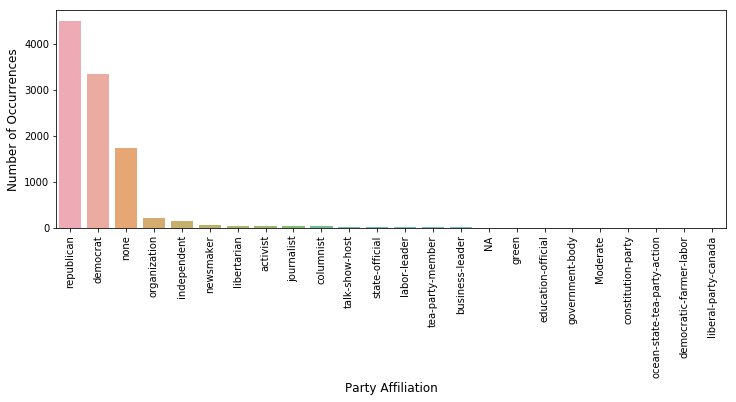

In [449]:
count_affiliation = data_slice_vectorizer['Party Affiliation'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(count_affiliation.index, count_affiliation.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Party Affiliation', fontsize=12)
plt.xticks(rotation=90)
plt.show();

#### Splitting the data into Training and Testing Data

In [450]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_slice_vectorizer['Statement'], data_slice_vectorizer['Party Affiliation'], random_state = 0)

#### Visualizing features of a particular document

In [451]:
print('X_train first entry: \n\n', X_train[0])
print('\n\nX_train shape: ', X_train.shape)

X_train first entry: 

 Says the Annies List political group supports third-trimester abortions on demand.


X_train shape:  (7701,)


#### Creation of TF-IDF Vectorizer

In [453]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(min_df = 5).fit(X_train)
len(vect.get_feature_names())

2842

#### Creation of a document-term matrix to identify individual documents by feature

In [454]:
X_train_vectorized = vect.transform(X_train)

#### Feature Extraction and Visualization of coefficients after application of TF-IDF

In [455]:
feature_names = np.array(vect.get_feature_names())

sorted_tfidf_index = X_train_vectorized.max(0).toarray()[0].argsort()

print('Smallest Tfidf: \n{}\n'.format(feature_names[sorted_tfidf_index[:10]]))
print('Largest Tfidf: \n{}\n'.format(feature_names[sorted_tfidf_index[:-11:-1]]))

Smallest Tfidf: 
['compare' 'short' 'residency' 'depend' 'so' 'though' 'patrol' 'further'
 'decreased' 'stage']

Largest Tfidf: 
['was' 'on' 'don' 'non' 'torture' 'parties' 'fraud' 'smaller' 'nra'
 'florida']



#### Applying Random Forest Classifier on Vectorized Data

In [456]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [457]:
rclf = RandomForestClassifier()

In [458]:
rclf.fit(X_train_vectorized,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Calculating Accuracy of the model

In [459]:
predictions = rclf.predict(vect.transform(X_test))
print(accuracy_score(y_test,predictions))

0.46417445482866043
